# Predict bank customers conversion probability

In [1]:
%matplotlib inline
import psycopg2
import pickle

# data processing
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve



# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Explainability
import shap

# Import Data

the dataset is available here: https://archive.ics.uci.edu/ml/datasets/bank+marketing

Find the best strategies to improve for the next marketing campaign. How can the financial institution have a greater effectiveness for future marketing campaigns? In order to answer this, we have to analyze the last marketing campaign the bank performed and identify the patterns that will help us find conclusions in order to develop future strategies.

## Attribute Information:

Input variables:
### bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
# load data from local csv 
df = pd.read_csv(
        filepath_or_buffer = '../data/bank-additional-full.csv',
        sep=';'
)

# drop a few columns which are typically not available in many scenarios or columns which leads to leakage b/c it cannot be known beforehand!
df.drop(
        labels=['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed'], 
        axis=1, 
        inplace=True)

# make feature denoting if there was a previous contact
df['previous_contact'] = (df['pdays'] != 999).apply(lambda x: 'no' if x==False else 'yes')

# insert random value if value equal 999 since the values is not defined
df['pdays'] = df['pdays'].apply(lambda x: np.nan if x==999 else x)

# encode target column
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else 1)

df.head()

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y,previous_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,0,no


## Utility Functions

In [3]:
def get_data_from_my_postgre_db(password:str, table_name:str)->pd.DataFrame:
    """connects to marketing_analytics db and returns data from table_name as pandas dataframe .
    inputs: database password and table_name"""
    # Connect to the database
    conn = psycopg2.connect(
        database="marketing_analytics", 
        user="postgres", 
        password=password, 
        host="localhost", 
        port="5432")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a SQL query
    #cur.execute("SELECT * FROM bank_customers_churn_dataset")
    cur.execute("SELECT * FROM " + table_name) 
    # Get the column names from the cursor description
    columns = [desc[0] for desc in cur.description]
    # Fetch the results i.e. values
    results = cur.fetchall()
    # Create a dictionary mapping column names to values
    data = [dict(zip(columns, row)) for row in results]
    # Close the connection
    conn.close()
    # turn dictionary into dataframe
    return pd.DataFrame.from_dict(data)

def create_missing_values(df:pd.DataFrame, na_percentage=0.05)->pd.DataFrame:
    """impute missing values in na_percentage of rows in each column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_missing_values = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X.columns:
        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_missing_values)
        for row in random_indices:  
            X.loc[row, col] = np.nan
    return X

def create_outliers(df:pd.DataFrame, numeric_columns:list, na_percentage=0.05)->pd.DataFrame:
    """impute outliers in na_percentage of rows in each numeric column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_outliers = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X[numeric_columns]:
        # get mean value, standard deviation and minimum
        mean, sd, min = X[col].mean(), X[col].std(), X[col].min()
        # Generate random numbers from normal distribution
        rand_norm = np.random.normal(mean, sd, 1000000)
        # Generate outliers which are at least mean+/-3*std
        if min < 0:
            outliers = np.append(rand_norm[rand_norm < mean-3*sd], rand_norm[rand_norm > mean+3*sd])
        else:
            outliers = rand_norm[rand_norm > mean+3*sd]

        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_outliers)
        for row in random_indices:
            X.loc[row, col] = random.sample(outliers.tolist(), 1)[0]
    return X

def plot_threshold_recall_precision_curves(model, X, y):
    """plot threshold-recall-precision curves given trained model X and y"""
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    y_scores = model.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, y_scores)

    ax[0].plot(recall, precision)
    ax[0].set_title("Precision-Recall Curve")
    ax[0].set_xlabel('recall')
    ax[0].set_ylabel('precision')
    ax[0].set_xlim(-0.05, 1.05)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].grid()

    ax[1].plot(recall, np.insert(thresholds, 0, 0))
    ax[1].set_title("Threshold-Recall Curve")
    ax[1].set_xlabel('recall')
    ax[1].set_ylabel('threshold')
    ax[1].set_xlim(-0.05, 1.05)
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].grid()
    return fig

def plot_confusion_matrix(features:pd.DataFrame, labels:np.array, sklearn_model, threshold=0.5):
    """plot confusion matrix for trained model given labels and one-hotencoded features. Pick a decision threshold for positive class"""
    # make predictions
    preds = sklearn_model.predict_proba(features)[:,1]
    preds = np.where(preds>threshold, 1, 0)
    # calc confusion matrix
    cm = confusion_matrix(labels, preds, labels=sklearn_model.classes_)
    # create matrix display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,                            
        display_labels=sklearn_model.classes_)
    disp.plot()
    plt.show()

In [4]:
#f = open("../private.txt", "r")
#pw = f.read()

In [5]:
## get data from postres db
#table_name = "bank_customers_churn_dataset"
#df = get_data_from_my_postgre_db(pw, table_name)
#
## set customer id as index
#df.set_index('customer_id', inplace=True)
#
## change churn column type to bool
#df['churn'] = df['churn'].astype('int').astype('bool')
#
## change data types to numeric
#df['tenure'] = df['tenure'].apply(lambda x: int(x))
#df['products_number'] = df['products_number'].apply(lambda x: int(x))
#df['credit_card'] = df['credit_card'].apply(lambda x: int(x))
#df['active_member'] = df['active_member'].apply(lambda x: int(x))
#
## change type of categorical columns "credit_card" and "active_member"
#df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
#df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

In [6]:
df.dtypes

age                   int64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
campaign              int64
pdays               float64
previous              int64
poutcome             object
y                     int64
previous_contact     object
dtype: object

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y,previous_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,0,no


## Split Features and Target

In [8]:
# divide features and target
y = df['y'].values
X = df.drop('y', axis=1)

## Check Column Types

In [9]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = X.select_dtypes(include=numerics).columns.to_list()
categorical_columns = X.select_dtypes(exclude=numerics).columns.to_list()

print('numeric columns: {}'.format(numeric_columns))
print('categorical columns: {}'.format(categorical_columns))

numeric columns: ['age', 'campaign', 'pdays', 'previous']
categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'previous_contact']


In [10]:
# check unique values for categorical values
for col in categorical_columns:
    print('unique values for {}: \n{}'.format(col, df[col].unique()))


unique values for job: 
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
unique values for marital: 
['married' 'single' 'divorced' 'unknown']
unique values for education: 
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
unique values for default: 
['no' 'unknown' 'yes']
unique values for housing: 
['no' 'yes' 'unknown']
unique values for loan: 
['no' 'yes' 'unknown']
unique values for contact: 
['telephone' 'cellular']
unique values for month: 
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
unique values for day_of_week: 
['mon' 'tue' 'wed' 'thu' 'fri']
unique values for poutcome: 
['nonexistent' 'failure' 'success']
unique values for previous_contact: 
['no' 'yes']


# Train-Test Split the Data

In [11]:
# way too much data for training; let´s split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.90, 
    stratify=y,
    random_state=123)

In [12]:
X_train.shape

(4118, 15)

In [13]:
X_test.shape

(37070, 15)

In [14]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,previous_contact
13583,25,technician,married,professional.course,no,no,no,cellular,jul,thu,3,NaN,0,nonexistent,no
5572,42,housemaid,married,basic.4y,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,no
4906,44,technician,married,high.school,unknown,yes,no,telephone,may,wed,2,NaN,0,nonexistent,no
24720,37,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,1,NaN,1,failure,no
1298,31,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,1,NaN,0,nonexistent,no


## Simulate Additional Missing Values and Outliers to Ensure the Methods for Recovery Work

In [15]:
# create some more missing data in 5% of all rows to ensure enough missing data to test the missing data imputation methods
X_train = create_missing_values(X_train, na_percentage=0.05)
X_test = create_missing_values(X_test, na_percentage=0.05)

In [16]:
# create additional outliers in 5% of the rows to test out outlier removal method
X_train = create_outliers(X_train, numeric_columns, 0.05)
X_test = create_outliers(X_test, numeric_columns, 0.05)

# Data Analysis Preparation

In [17]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,previous_contact
13583,25.000000,technician,married,professional.course,no,no,no,cellular,jul,thu,3.000000,NaN,0.0,nonexistent,no
5572,42.000000,housemaid,married,basic.4y,no,yes,no,telephone,may,mon,11.274069,16.337715,0.0,nonexistent,no
4906,74.796603,technician,married,high.school,unknown,yes,no,telephone,may,wed,2.000000,NaN,NaN,nonexistent,no
24720,37.000000,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,1.000000,NaN,1.0,failure,no
1298,70.736712,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,1.000000,NaN,0.0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10745,34.000000,NaN,single,professional.course,no,no,no,telephone,NaN,tue,2.000000,NaN,0.0,nonexistent,no
16796,41.000000,entrepreneur,single,high.school,no,yes,no,cellular,jul,thu,1.000000,NaN,0.0,nonexistent,no
35500,46.000000,blue-collar,married,basic.9y,no,yes,no,cellular,may,mon,1.000000,NaN,NaN,nonexistent,no
21528,50.000000,blue-collar,married,basic.4y,no,yes,no,cellular,aug,tue,1.000000,NaN,0.0,nonexistent,no


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4118 entries, 13583 to 24475
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3918 non-null   float64
 1   job               3913 non-null   object 
 2   marital           3913 non-null   object 
 3   education         3913 non-null   object 
 4   default           3913 non-null   object 
 5   housing           3913 non-null   object 
 6   loan              3913 non-null   object 
 7   contact           3913 non-null   object 
 8   month             3913 non-null   object 
 9   day_of_week       3913 non-null   object 
 10  campaign          3924 non-null   float64
 11  pdays             339 non-null    float64
 12  previous          3923 non-null   float64
 13  poutcome          3913 non-null   object 
 14  previous_contact  3913 non-null   object 
dtypes: float64(4), object(11)
memory usage: 643.8+ KB


In [19]:
X_train.isna().sum()

age                  200
job                  205
marital              205
education            205
default              205
housing              205
loan                 205
contact              205
month                205
day_of_week          205
campaign             194
pdays               3779
previous             195
poutcome             205
previous_contact     205
dtype: int64

## Impute Missing Values

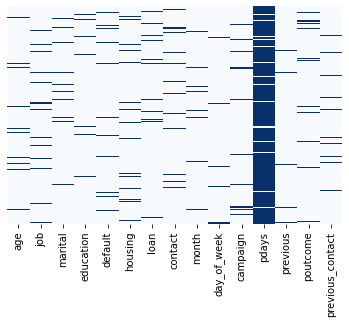

In [20]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [21]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,age,campaign,pdays,previous
13583,25.000000,3.000000,16.360545,0.0
5572,42.000000,11.274069,16.337715,0.0
4906,74.796603,2.000000,16.360545,0.0
24720,37.000000,1.000000,16.360545,1.0
1298,70.736712,1.000000,16.360545,0.0


In [22]:
# impute missing numeric values in test dataset
X_test_numeric = numeric_imputer.transform(X_test.select_dtypes(include=numerics))
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_columns, index=X_test.index)
X_test_numeric.head()

,age,campaign,pdays,previous
9909,55.0,1.0,16.360545,0.0
8714,38.0,4.0,16.360545,0.0
11249,40.0,2.0,16.360545,0.0
26948,31.0,3.0,16.360545,0.0
11755,53.0,3.0,16.360545,0.0


In [23]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,technician,married,professional.course,no,no,no,cellular,jul,thu,nonexistent,no
5572,housemaid,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [24]:
# Impute missing categorical values in test dataset
X_test_categorical = categorical_imputer.transform(X_test.select_dtypes(exclude=numerics))
X_test_categorical = pd.DataFrame(X_test_categorical, columns=categorical_columns, index=X_test.index)
X_test_categorical.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,technician,married,university.degree,no,yes,no,telephone,jun,mon,nonexistent,no


In [25]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [26]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,25.000000,3.000000,16.360545,0.0,technician,married,professional.course,no,no,no,cellular,jul,thu,nonexistent,no
5572,42.000000,11.274069,16.337715,0.0,housemaid,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,74.796603,2.000000,16.360545,0.0,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,37.000000,1.000000,16.360545,1.0,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,70.736712,1.000000,16.360545,0.0,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [27]:
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,55.0,1.0,16.360545,0.0,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,38.0,4.0,16.360545,0.0,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,40.0,2.0,16.360545,0.0,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,31.0,3.0,16.360545,0.0,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,53.0,3.0,16.360545,0.0,technician,married,university.degree,no,yes,no,telephone,jun,mon,nonexistent,no


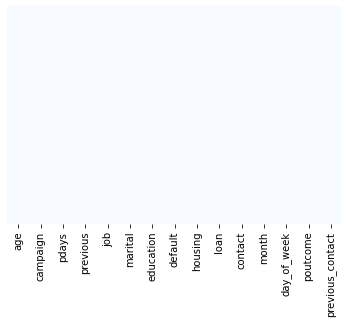

In [28]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_test.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Prepare Categorical Features

In [29]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category job: 
admin.           1219
blue-collar       872
technician        607
services          406
management        271
entrepreneur      142
self-employed     142
retired           137
unemployed        122
housemaid          94
student            83
unknown            23
Name: job, dtype: int64
Value counts in category marital: 
married     2583
single      1096
divorced     432
unknown        7
Name: marital, dtype: int64
Value counts in category education: 
university.degree      1378
high.school             934
basic.9y                592
professional.course     469
basic.4y                374
basic.6y                205
unknown                 166
Name: education, dtype: int64
Value counts in category default: 
no         3336
unknown     782
Name: default, dtype: int64
Value counts in category housing: 
yes        2235
no         1781
unknown     102
Name: housing, dtype: int64
Value counts in category loan: 
no         3440
yes         577
unknown     101
N

## Encode Rare Labels

In [30]:
# encode rare labels in train data
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=5)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable marital is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable default is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable housing is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable loan is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable contact is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable day_of_week is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable poutcome is less than that indicated in n_categories. Thus, all categori

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,technician,married,professional.course,no,no,no,cellular,jul,thu,nonexistent,no
5572,Rare,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,Rare,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [31]:
# encode rare labels in test data
X_test[categorical_columns] = rare_encoder.transform(X_test[categorical_columns])
X_test[categorical_columns].head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,technician,married,university.degree,no,yes,no,telephone,jun,mon,nonexistent,no


In [32]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Prepare Numerical Features

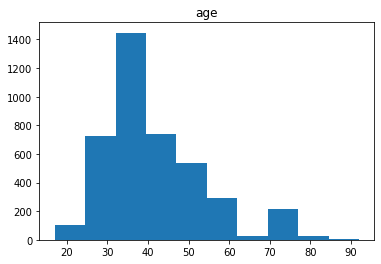

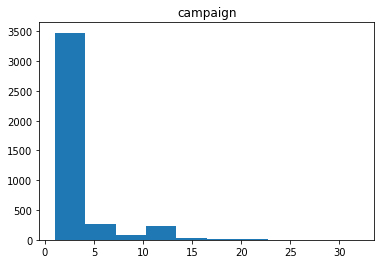

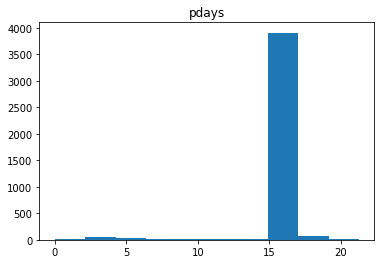

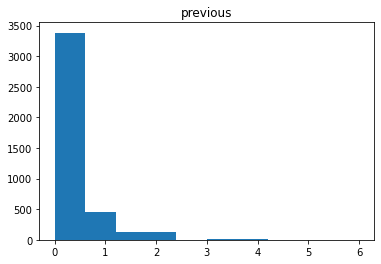

In [33]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [34]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [35]:
# fit the capper on train data
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,25.000000,3.000000,16.360545,0.0,technician,married,professional.course,no,no,no,cellular,jul,thu,nonexistent,no
5572,42.000000,11.274069,16.337715,0.0,Rare,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,74.796603,2.000000,16.360545,0.0,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,37.000000,1.000000,16.360545,1.0,Rare,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,70.736712,1.000000,16.360545,0.0,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [36]:
# fit the capper on test data
X_test[numeric_columns] = capper.transform(X_test[numeric_columns])
X_test.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,55.0,1.0,16.360545,0.0,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,38.0,4.0,16.360545,0.0,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,40.0,2.0,16.360545,0.0,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,31.0,3.0,16.360545,0.0,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,53.0,3.0,16.360545,0.0,technician,married,university.degree,no,yes,no,telephone,jun,mon,nonexistent,no


In [37]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

# Data Visualization

## Visualize Numerical Features

In [38]:
# create numeric data frame
data = pd.concat([X_train[numeric_columns], pd.DataFrame(y_train, index=X_train.index, columns=['converter'])], axis=1)
data.head()

,age,campaign,pdays,previous,converter
13583,25.000000,3.000000,16.360545,0.0,0
5572,42.000000,11.274069,16.337715,0.0,0
4906,74.796603,2.000000,16.360545,0.0,0
24720,37.000000,1.000000,16.360545,1.0,0
1298,70.736712,1.000000,16.360545,0.0,0


In [39]:
data.groupby('converter').agg('median')

,age,campaign,pdays,previous
converter,,,,
0,39.0,2.0,16.360545,0.0
1,38.0,2.0,16.360545,0.0


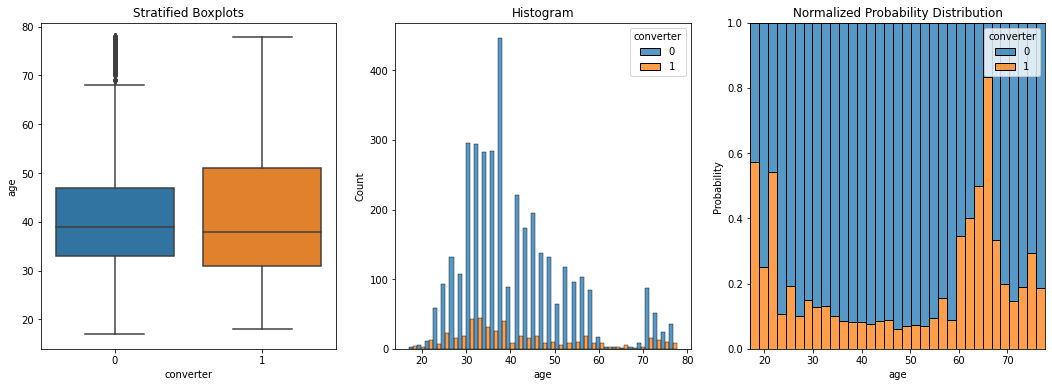

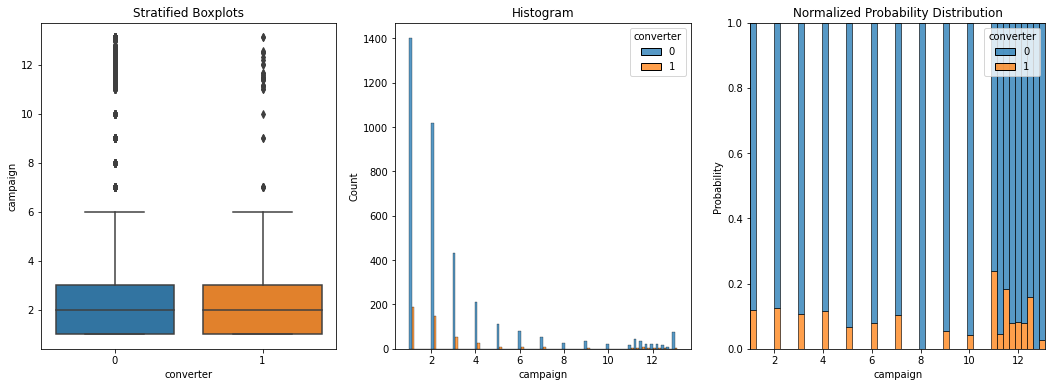

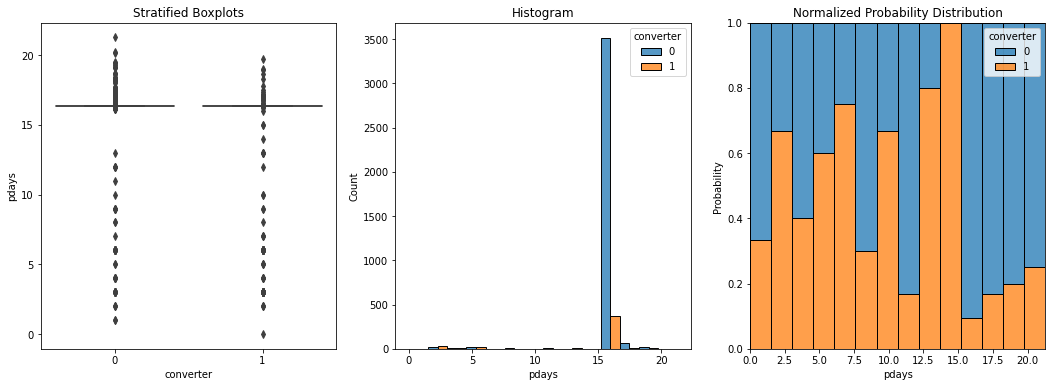

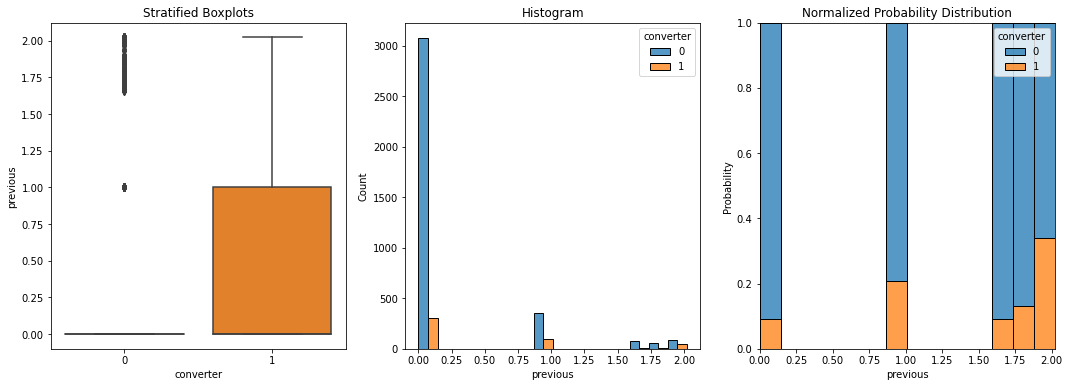

In [40]:
# plot box-plots and histograms
for feat in numeric_columns:

    fig, ax = plt.subplots(1, 3, figsize=(18,6))

    sns.boxplot(
        data = data,
        y = feat,
        x = 'converter',
        ax=ax[0]
    )
    ax[0].set_title('Stratified Boxplots')

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='count',
        multiple='dodge',
        ax = ax[1]
    )
    ax[1].set_title('Histogram')

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='probability',
        multiple='fill',
        ax = ax[2]
    )
    ax[2].set_title('Normalized Probability Distribution')

    plt.show()

## Visualize Categorical Features

In [41]:
# create categorical data frame
data = pd.concat([X_train[categorical_columns], pd.DataFrame(y_train, index=X_train.index, columns=['converter'])], axis=1)
data.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact,converter
13583,technician,married,professional.course,no,no,no,cellular,jul,thu,nonexistent,no,0
5572,Rare,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no,0
4906,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no,0
24720,Rare,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no,0
1298,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no,0


In [42]:
data.groupby('converter').agg(pd.Series.mode)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
converter,,,,,,,,,,,
0,admin.,married,university.degree,no,yes,no,cellular,may,mon,nonexistent,no
1,admin.,married,university.degree,no,yes,no,cellular,Rare,thu,nonexistent,no


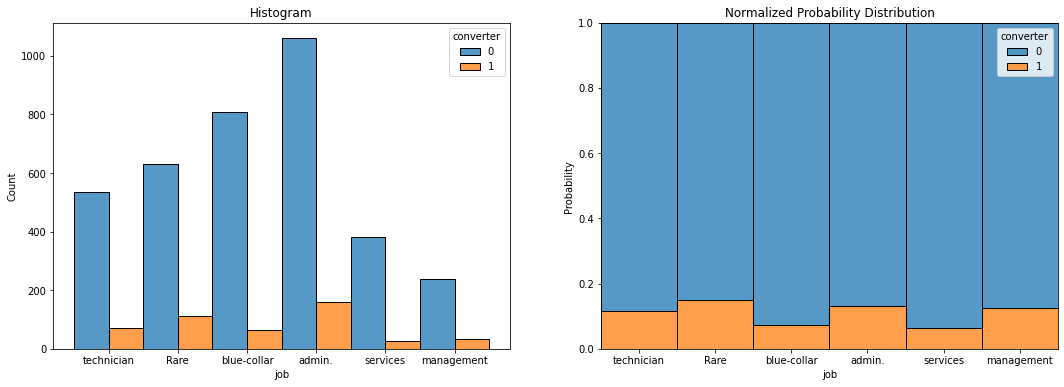

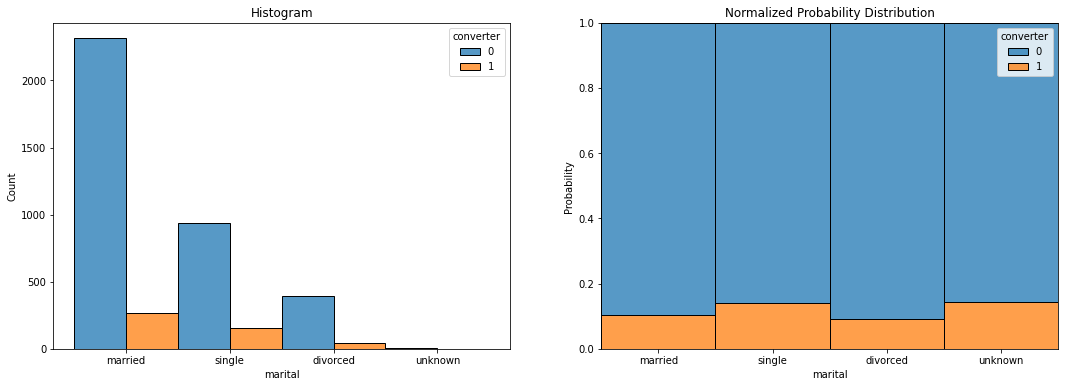

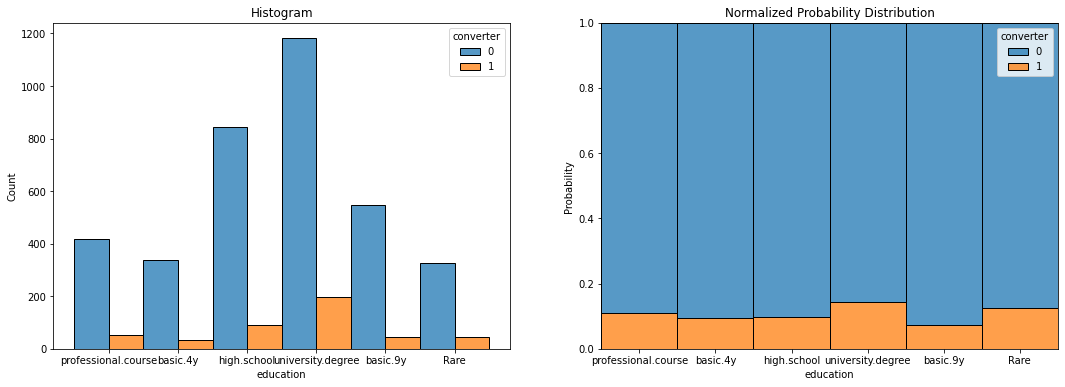

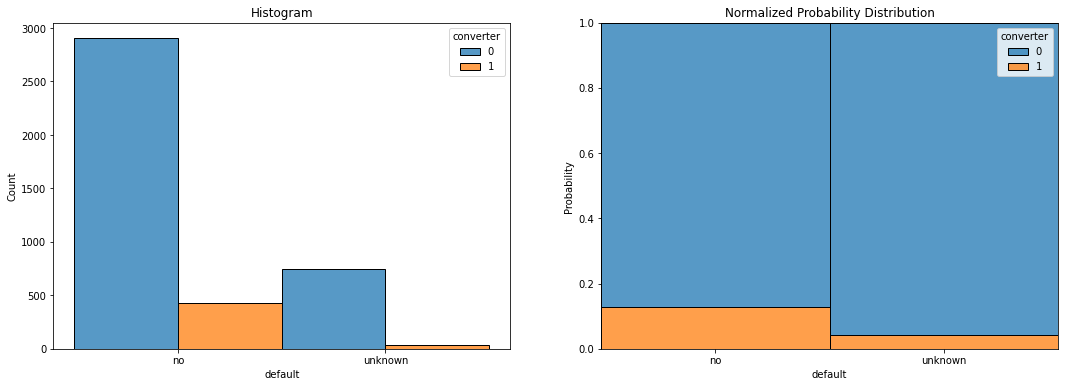

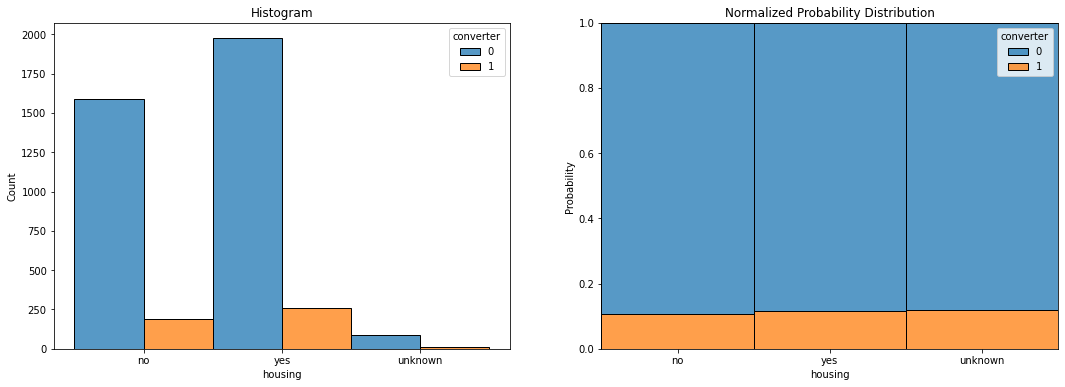

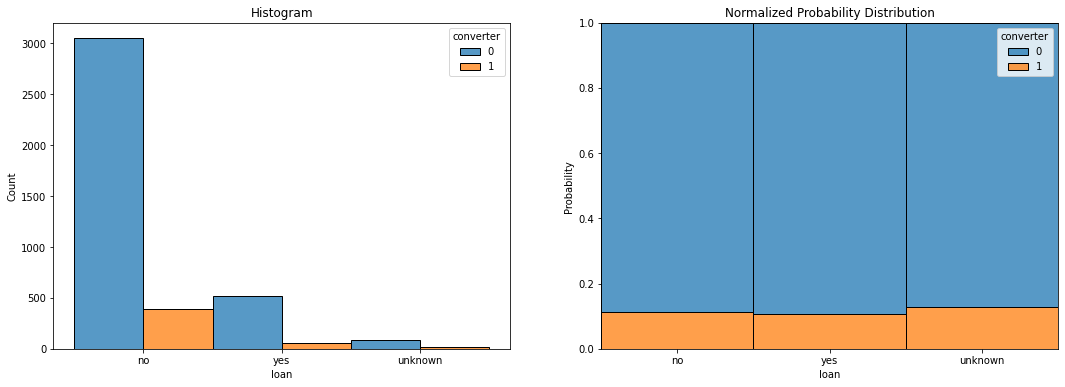

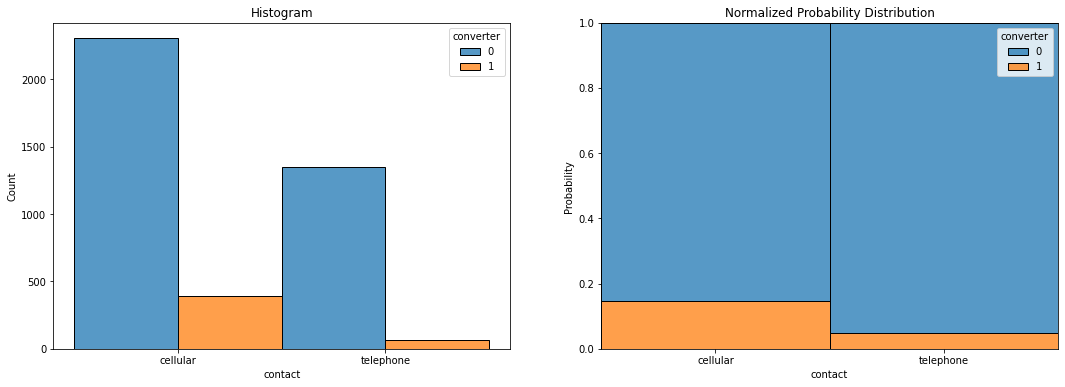

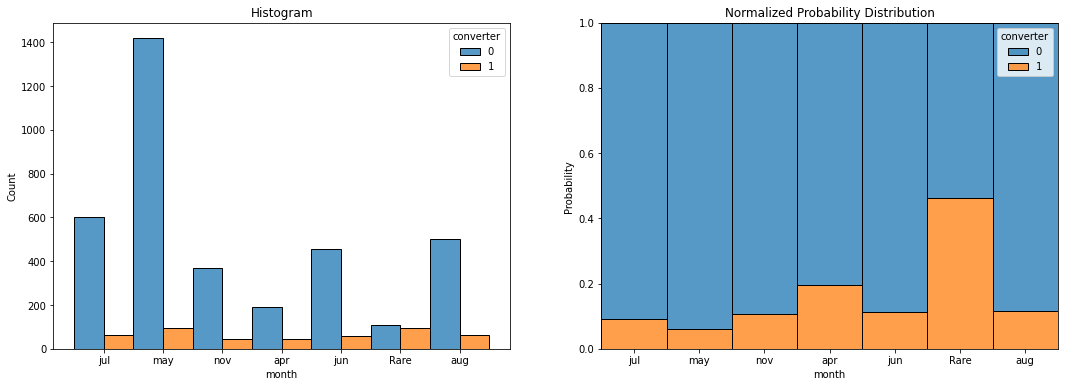

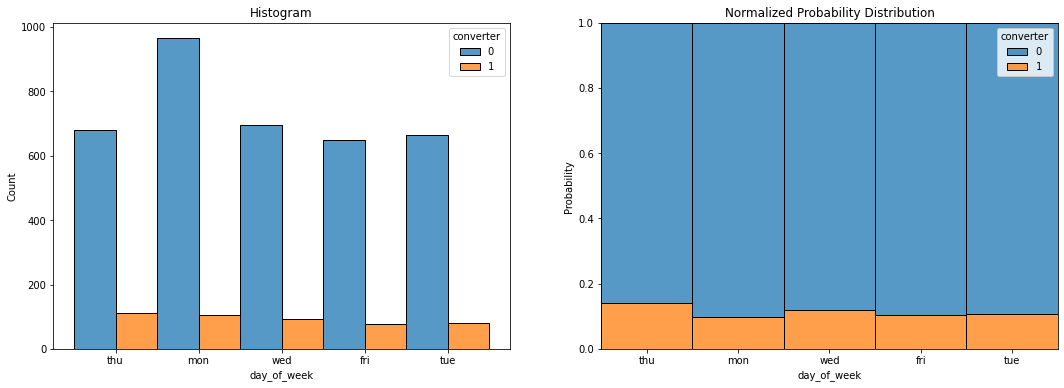

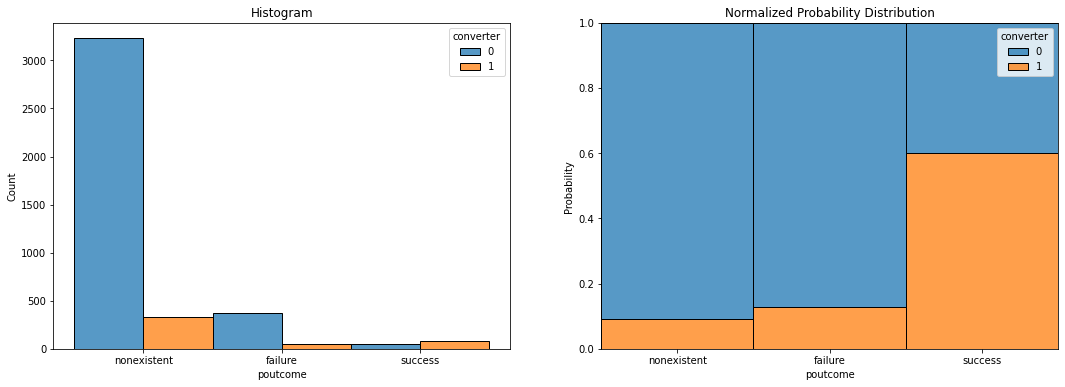

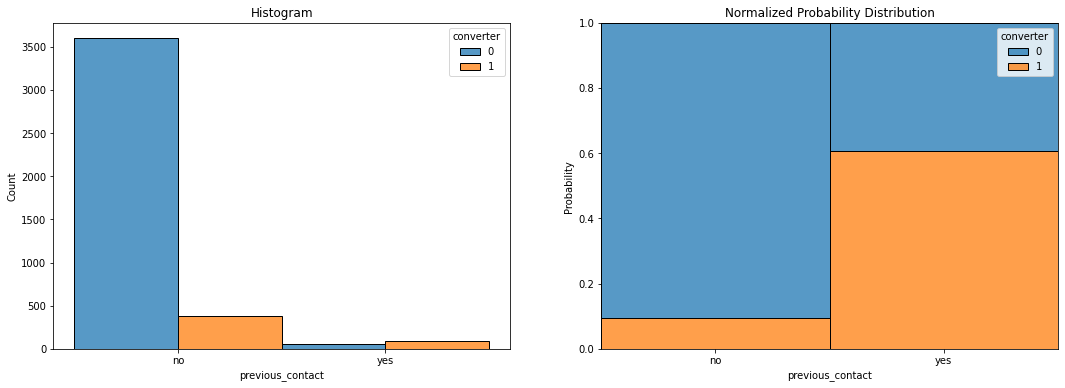

In [43]:
# plot histograms
for feat in categorical_columns:

    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='count',
        multiple='dodge',
        ax = ax[0]
    )
    ax[0].set_title('Histogram')

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='probability',
        multiple='fill',
        ax = ax[1]
    )
    ax[1].set_title('Normalized Probability Distribution')

    plt.show()

## One-Hote Encoding

In [44]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [45]:
# hotencode train data
X_train_hot_enc = enc.fit_transform(X_train[categorical_columns])
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc.head()

,age,campaign,pdays,previous,job_admin.,job_blue-collar,job_management,job_services,job_technician,marital_married,...,month_jun,month_may,month_nov,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,previous_contact_yes
13583,25.000000,3.000000,16.360545,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5572,42.000000,11.274069,16.337715,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4906,74.796603,2.000000,16.360545,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
24720,37.000000,1.000000,16.360545,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1298,70.736712,1.000000,16.360545,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [46]:
# hotencode test data
X_test_hot_enc = enc.transform(X_test[categorical_columns])
X_test_cat_hotenc = pd.DataFrame(X_test_hot_enc, columns=enc.get_feature_names_out()) 
X_test_cat_hotenc.index = X_test.index 
X_test_hotenc = pd.concat([X_test[numeric_columns], X_test_cat_hotenc], axis=1) 
X_test_hotenc.head()

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros


,age,campaign,pdays,previous,job_admin.,job_blue-collar,job_management,job_services,job_technician,marital_married,...,month_jun,month_may,month_nov,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,previous_contact_yes
9909,55.0,1.0,16.360545,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8714,38.0,4.0,16.360545,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
11249,40.0,2.0,16.360545,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
26948,31.0,3.0,16.360545,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
11755,53.0,3.0,16.360545,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [47]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

# Training Sklearn Random Forest

In [48]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [49]:
rf.fit(X_train_hotenc, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [50]:
# evaluate accuracy on training set
rf.score(X_train_hotenc, y_train)

0.906750849927149

In [51]:
# evaluate accuracy on test set
rf.score(X_test_hotenc, y_test)

0.8978958726733207

### Tuning Random Forest

In [52]:
# parameters for Random Forest
parameters = {
    'n_estimators': (50, 100, 200, 400),
    'max_depth': (3, 5, None),
    'min_samples_split': (1, 3, 6),
    'min_samples_leaf': (1, 3, 6),
    }

model = GridSearchCV(
    rf, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-1)

In [53]:
model.fit(X_train_hotenc, y_train)


108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'min_samples_leaf': (1, 3, 6),
                         'min_samples_split': (1, 3, 6),
                         'n_estimators': (50, 100, 200, 400)},
             scoring=make_scorer(recall_score))

In [54]:
# evaluate accuracy on training set
model.score(X_train_hotenc, y_train)

0.3426724137931034

In [55]:
# evaluate accuracy on test set
model.score(X_test_hotenc, y_test)

0.17504789272030652

# Training Sklearn Gradient Boosting

In [56]:
gb = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=3,
    max_features='log2', 
    random_state=123)

In [57]:
gb.fit(X_train_hotenc, y_train)

GradientBoostingClassifier(max_features='log2', random_state=123)

In [58]:
# evaluate accuracy on training set
gb.score(X_train_hotenc, y_train)

0.9035939776590578

In [59]:
# evaluate accuracy on test set
gb.score(X_test_hotenc, y_test)

0.8973833288373347

### Tuning Gradient Boosting

In [60]:
# parameters for Gradient Boosting
parameters = {
    'n_estimators': (50, 100, 200),
    'max_depth': (3, 5, 7),
    }

model = GridSearchCV(
    gb, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-1)

In [61]:
model.fit(X_train_hotenc, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_features='log2',
                                                  random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, 7),
                         'n_estimators': (50, 100, 200)},
             scoring=make_scorer(recall_score))

In [62]:
# evaluate accuracy on training set
model.score(X_train_hotenc, y_train)

0.2413793103448276

In [63]:
# evaluate accuracy on test set
model.score(X_test_hotenc, y_test)

0.17025862068965517

In [64]:
model.best_params_

{'max_depth': 3, 'n_estimators': 200}

In [65]:
# Save the BEST classifier!!!
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model, filename)

# Model Evaluation

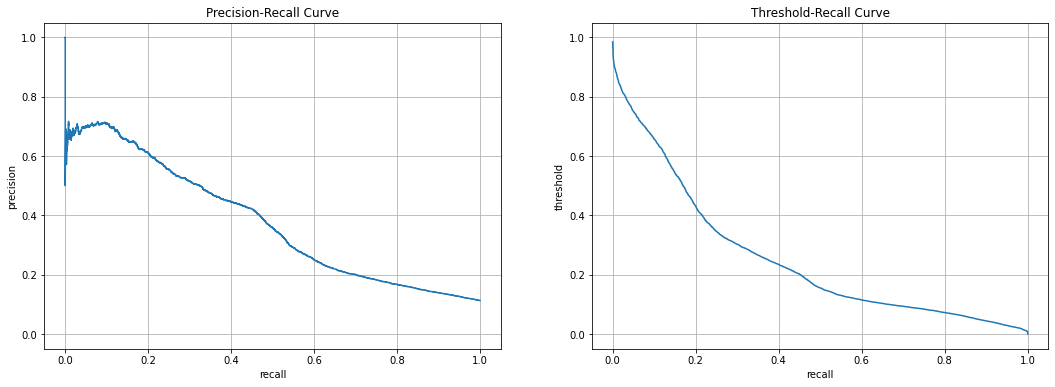

In [66]:
fig = plot_threshold_recall_precision_curves(model, X_test_hotenc, y_test)

In [67]:
# lets say for whatever reason we want the recall to be around 40%, hence we accept a precision of around 40%; therefore we need to choose a threshold of around 30%
# let´s relabel using that threshold of 20%

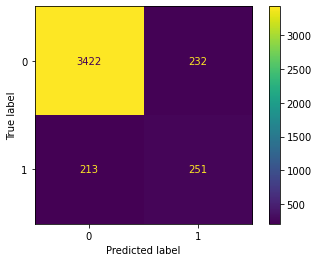

In [68]:
# plot confusion matrix for training data
plot_confusion_matrix(
    features=X_train_hotenc, 
    labels=y_train, 
    sklearn_model=model,
    threshold=0.2)

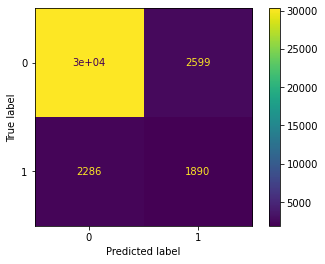

In [69]:
# plot confusion matrix for test data
plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model,
    threshold=0.2)

# Model Explainability Using Shap Values

In [70]:
X_test_hotenc.shape

(37070, 36)

In [71]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_,
    feature_perturbation = 'interventional',
    output = 'probability')

# get random sample
X = X_test_hotenc.sample(1000)

# calculate shap values
shap_values = explainer.shap_values(X)

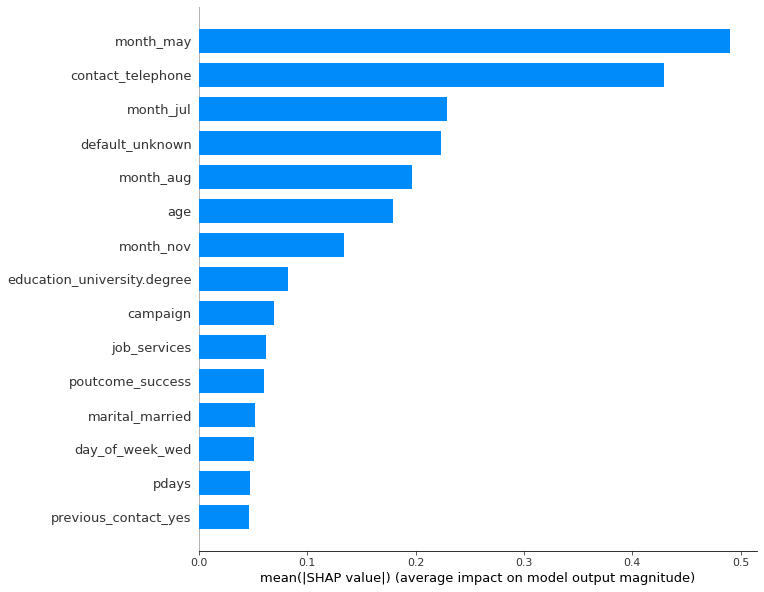

In [72]:
shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=True,
    max_display=15,
    plot_size=(10.0,10.0),
    plot_type='bar'
)

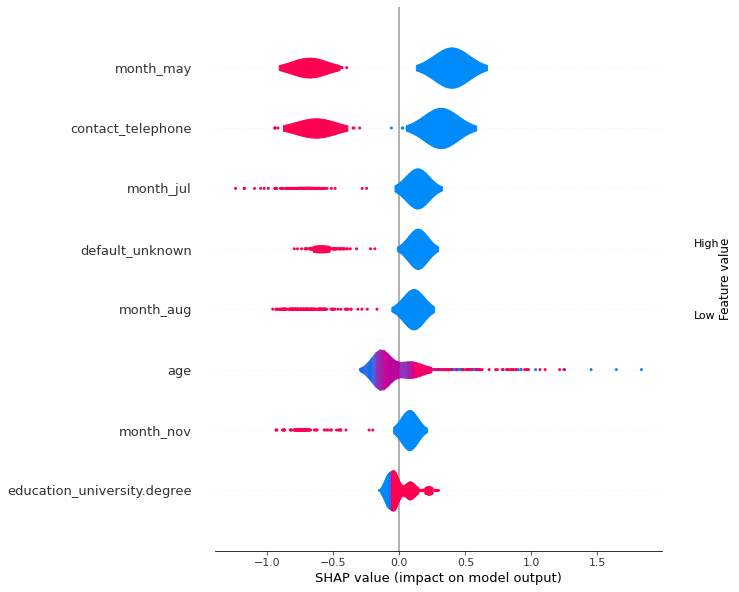

In [73]:
shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=True,
    max_display=8,
    plot_size=(10.0,10.0),
    plot_type='violin'
)

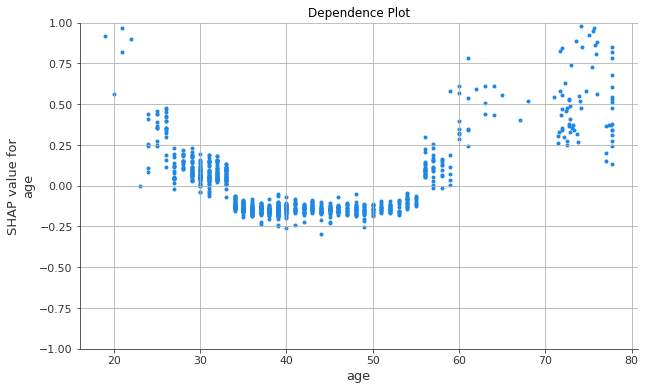

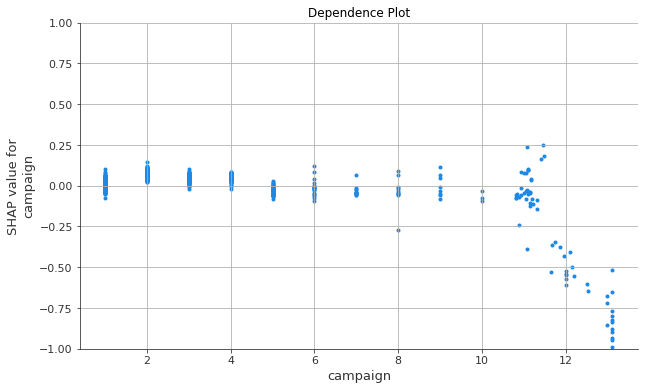

In [74]:
# plot dependence plots for the numerical features
for feat in ['age','campaign']:
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.grid()
    ax.set_title('Dependence Plot')
    ax.set_ylim(-1,1)
    shap.dependence_plot(
        ind = feat,
        shap_values = shap_values, 
        features = X,
        interaction_index=None,
        ax=ax
    )
    